# Problem Statement

Nothing is more comforting than being greeted by your favorite drink just as you walk through the door of the corner café. While a thoughtful barista knows you take a macchiato every Wednesday morning at 8:15, it’s much more difficult in a digital space for your preferred brands to personalize your experience.

TalkingData, China’s largest third-party mobile data platform, understands that everyday choices and behaviors paint a picture of who we are and what we value. Currently, TalkingData is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences.

In this notebook we will build a model to predict users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

# Metrics 

1. Can we predict the demographics of a user (gender and age) based on their app download and usage behaviors?
2. 

# Data

The data schema can be represented in the following chart:

File descriptions

- gender_age_train.csv, gender_age_test.csv - the training and test set
- group: this is the target variable you are going to predict
- events.csv, app_events.csv - when a user uses TalkingData SDK, the event gets logged in this data. Each event has an event id, location (lat/long), and the event corresponds to a list of apps in app_events.
- timestamp: when the user is using an app with TalkingData SDK
- app_labels.csv - apps and their labels, the label_id's can be used to join with label_categories
- label_categories.csv - apps' labels and their categories in text
- phone_brand_device_model.csv - device ids, brand, and models
- phone_brand: note that the brands are in Chinese (translation courtesy of user fromandto) 
    - 三星 samsung
    - 天语 Ktouch
    - 海信 hisense
    - 联想 lenovo
    - 欧比 obi
    - ...
- sample_submission.csv - a sample submission file in the correct format

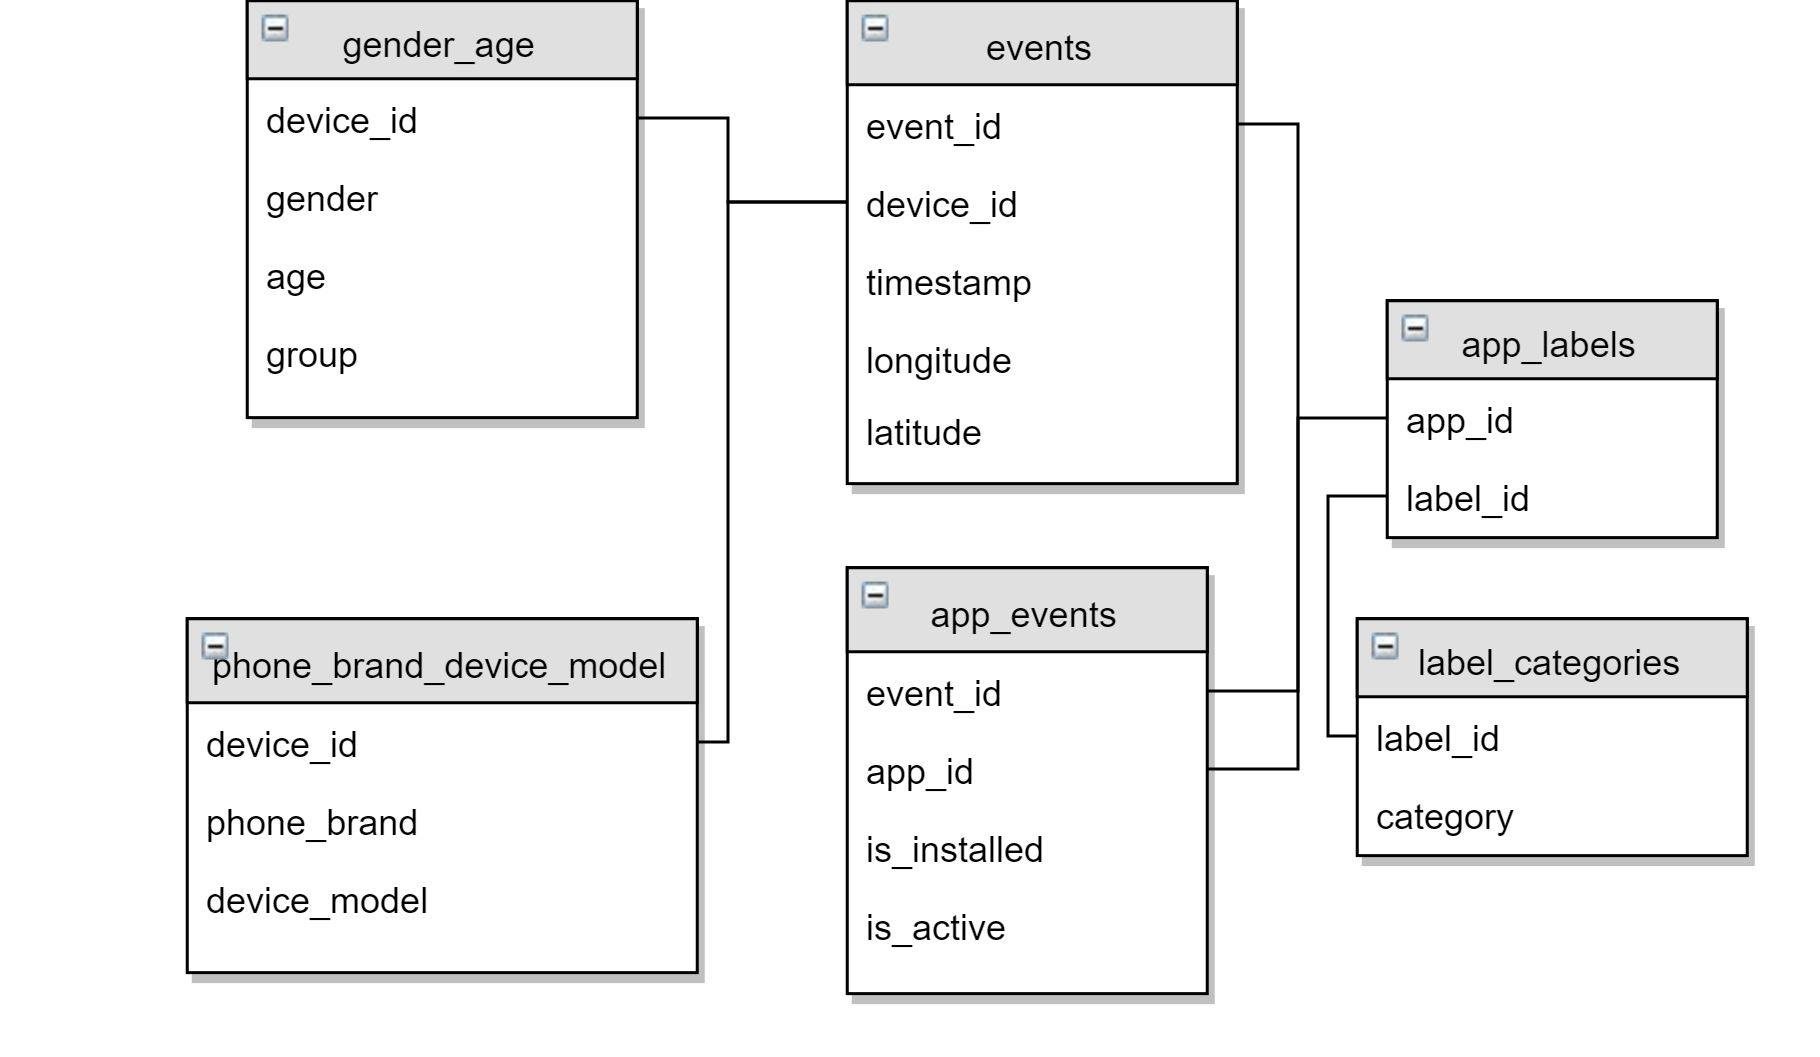

In [1]:
from IPython.display import Image
Image(filename='RelationalDatabasesFlow.jpg')

In [13]:
import os
import pyspark.mllib
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import pyspark
import urllib

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from IPython.display import display, HTML

get_ipython().magic(u'pylab inline')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sinh', 'trunc', 'f', 'tan', 'cosh', 'rank', 'radians', 'sin', 'mean', 'log2', 'expm1', 'rand', 'rint', 'array', 'size', 'broadcast', 'exp', 'sum', 'randn', 'ceil', 'isnan', 'repeat', 'cos', 'degrees', 'tanh', 'sqrt', 'split', 'cbrt', 'test', 'hypot', 'log', 'log10', 'log1p', 'floor', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
### Initialize streaming context
conf = SparkConf()\
                .setMaster("local[2]")\
                .setAppName("MobileAnalytics")\
                .set("spark.executor.memory", "2g")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

In [66]:
# train = spark.read.csv("data/gender_age_train.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# test = spark.read.csv("data/gender_age_test.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# events = spark.read.csv("data/events.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# label_categories = spark.read.csv("data/label_categories.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# phone = spark.read.csv("data/phone_brand_device_model.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# phone = phone.dropDuplicates() # Drop the 523 rows that were duplicated in this df
# app_events = spark.read.csv("data/app_events.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# app_labels = spark.read.csv("data/app_labels.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# train
train = sc.textFile("data/gender_age_train.csv", use_unicode=False)
train_header = train.first()
train = train.filter(lambda x: x != train_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
                device_id=str(x[0]),
                gender=str(x[1]),
                age=int(x[2]),
                group=str(x[3])
          ))\
          .toDF()
# test
test = sc.textFile("data/gender_age_test.csv", use_unicode=False) 
test_header = train.first()
test = test.filter(lambda x: x != test_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
              device_id=str(x[0])
          )) \
          .toDF()
# events
events = sc.textFile("data/events.csv", use_unicode=False) 
events_header = events.first()
events = events.filter(lambda x: x != events_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
              event_id=str(x[0]),
              device_id=str(x[1]),
              timestamp=str(x[2]),
              longitude=str(x[3]),
              latitude=str(x[4])
          )) \
          .toDF()            

# label_categories
label_categories = sc.textFile("data/label_categories.csv", use_unicode=False) 
label_categories_header = label_categories.first()
label_categories = label_categories.filter(lambda x: x != label_categories_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
              label_id=str(x[0]),
              category=str(x[1])
          )) \
          .toDF()              
            
# phone
phone = spark.read.csv("data/phone_brand_device_model.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
phone = phone.dropDuplicates() # Drop the 523 rows that were duplicated in this df

# app_events
app_events = spark.read.csv("data/app_events.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")

print events.show()

# app_labels
app_labels = spark.read.csv("data/app_labels.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")

print app_labels.show()


+--------------------+--------+--------+---------+-------------------+
|           device_id|event_id|latitude|longitude|          timestamp|
+--------------------+--------+--------+---------+-------------------+
|   29182687948017175|       1|   31.24|   121.38|2016-05-01 00:55:25|
|-6401643145415154744|       2|   30.97|   103.65|2016-05-01 00:54:12|
|-4833982096941402721|       3|   29.70|   106.60|2016-05-01 00:08:05|
|-6815121365017318426|       4|   23.28|   104.27|2016-05-01 00:06:40|
|-5373797595892518570|       5|   28.66|   115.88|2016-05-01 00:07:18|
| 1476664663289716375|       6|    0.00|     0.00|2016-05-01 00:27:21|
| 5990807147117726237|       7|   23.00|   113.73|2016-05-01 00:15:13|
| 1782450055857303792|       8|   34.70|   113.94|2016-05-01 00:15:35|
|-2073340001552902943|       9|    0.00|     0.00|2016-05-01 00:15:33|
|-8195816569128397698|      10|   26.04|   119.34|2016-05-01 00:41:31|
| 8663743929678393765|      11|   39.51|   106.71|2016-05-01 00:44:13|
| 8663

In [44]:
label_categories.show(10)

+--------------------+--------+
|            category|label_id|
+--------------------+--------+
|                    |       1|
|      game-game type|       2|
|    game-Game themes|       3|
|      game-Art Style|       4|
|   game-Leisure time|       5|
| game-Cutting things|       6|
|  game-Finding fault|       7|
|game-stress reliever|       8|
|            game-pet|       9|
|         game-Answer|      10|
+--------------------+--------+
only showing top 10 rows



In [5]:
train.show(10)

+---+--------------------+------+------+
|age|           device_id|gender| group|
+---+--------------------+------+------+
| 35|-8076087639492063270|     M|M32-38|
| 35|-2897161552818060146|     M|M32-38|
| 35|-8260683887967679142|     M|M32-38|
| 30|-4938849341048082022|     M|M29-31|
| 30|  245133531816851882|     M|M29-31|
| 24|-1297074871525174196|     F|F24-26|
| 36|  236877999787307864|     M|M32-38|
| 38|-8098239495777311881|     M|M32-38|
| 33|  176515041953473526|     M|M32-38|
| 36| 1596610250680140042|     F|F33-42|
+---+--------------------+------+------+
only showing top 10 rows



In [52]:
combined_data = app_labels.alias('app_labels').join(label_categories.alias('label_categories'), col('app_labels.label_id') == col('label_categories.label_id'))
combined_data = combined_data.alias('combined_data').join(app_events.alias('app_events'), col('combined_data.app_id') == col('app_events.app_id'))
combined_data = combined_data.alias('combined_data').join(events.alias('events'), col('combined_data.event_id') == col('events.event_id'))
combined_data.show()

+--------------------+--------+--------------------+--------+--------+--------------------+------------+---------+-------------------+--------+--------+---------+-------------------+
|              app_id|label_id|            category|label_id|event_id|              app_id|is_installed|is_active|          device_id|event_id|latitude|longitude|          timestamp|
+--------------------+--------+--------------------+--------+--------+--------------------+------------+---------+-------------------+--------+--------+---------+-------------------+
| -628177381309085483|     179|               video|     179|     463| -628177381309085483|           1|        1|7874748103544022938|     463|    0.00|     0.00|2016-05-04 00:23:21|
| -628177381309085483|     158|                news|     158|     463| -628177381309085483|           1|        1|7874748103544022938|     463|    0.00|     0.00|2016-05-04 00:23:21|
|-6344200655430756792|      42| poker game_doudizhu|      42|     463|-63442006554307

In [65]:
device_data = train.alias('train').join(phone.alias('phone'), col('train.device_id') == col('phone.device_id'))
device_data = device_data.alias('device_data').join(events.alias('events'), col('events.device_id') == col('device_data.device_id'))
device_data.show()

AnalysisException: u"Reference 'device_data.device_id' is ambiguous, could be: device_id#1696, device_id#1736L.;"

In [54]:
# https://stackoverflow.com/questions/32982425/encode-and-assemble-multiple-features-in-pyspark

One-hot encoding maps a column of label indices to a column of binary vectors, with at most a single one-value. This encoding allows algorithms which expect continuous features, such as Logistic Regression, to use categorical features.

In [42]:
# brandencoder = LabelEncoder().fit(phone.phone_brand)
# phone['brand'] = brandencoder.transform(phone['phone_brand'])
# print phone
# modelencoder = LabelEncoder().fit(phone.device_model)
# phone['model'] = modelencoder.transform(phone['device_model'])
    
phone_indexed = StringIndexer(inputCol="phone_brand", outputCol="phone_brand_index") \
                    .fit(phone) \
                    .transform(phone)
        
phone = OneHotEncoder(inputCol="phone_brand_index", outputCol="phone_brand_vec") \
                    .transform(phone_indexed)

#phone Model    
model_indexed = StringIndexer(inputCol="device_model", outputCol="device_model_index") \
                    .fit(phone) \
                    .transform(phone)
        
phone = OneHotEncoder(inputCol="device_model_index", outputCol="device_model_vec") \
                    .transform(model_indexed)

# phone = StringIndexer(inputCol="device_model", outputCol="device_model_index") \
#                     .fit(phone) \
#                     .transform(phone)

print phone.show()

+--------------------+-----------+---------------+-----------------+----------------+------------------+------------------+
|           device_id|phone_brand|   device_model|phone_brand_index| phone_brand_vec|device_model_index|  device_model_vec|
+--------------------+-----------+---------------+-----------------+----------------+------------------+------------------+
|-5117743377362882952|       vivo|           Y20T|              3.0| (130,[3],[1.0])|             149.0|(1598,[149],[1.0])|
| 5110524159866301228|         三星|      Galaxy S4|              1.0| (130,[1],[1.0])|               5.0|  (1598,[5],[1.0])|
|-7072818825604244920|         华为|      Ascend P7|              2.0| (130,[2],[1.0])|              27.0| (1598,[27],[1.0])|
|-5676755765420948706|         小米|           MI 3|              0.0| (130,[0],[1.0])|               1.0|  (1598,[1],[1.0])|
|-6149728339109419295|         酷派|           8729|              6.0| (130,[6],[1.0])|             263.0|(1598,[263],[1.0])|
|-555252

### Merge the train and test dfs with the encoded phone df so it can be more easily accessible

In [7]:
train_2 = train.join(phone, "device_id", "left")
test_2 = test.join(phone, "device_id", "left")
print train_2.show()
# train2 = pd.merge(train,phone,how='left', on='device_id')
# test2 = pd.merge(test,phone,how='left',on='device_id')
# train2.head(

+--------------------+---+------+------+-----------------+-----------+-----------------+----------------+------------------+------------------+
|           device_id|age|gender| group|     device_model|phone_brand|phone_brand_index| phone_brand_vec|device_model_index|  device_model_vec|
+--------------------+---+------+------+-----------------+-----------+-----------------+----------------+------------------+------------------+
| -101895266167311282| 26|     F|F24-26|        Galaxy S4|     ä¸æ|              1.0| (130,[1],[1.0])|               5.0|  (1598,[5],[1.0])|
|-1032421229388084233| 26|     M|M23-26|              MX4|     é­æ|              5.0| (130,[5],[1.0])|              24.0| (1598,[24],[1.0])|
|-1039701474753771322| 38|     M|M32-38|             MI 4|     å°ç±³|              0.0| (130,[0],[1.0])|               4.0|  (1598,[4],[1.0])|
|-1085119640476296324| 28|     M|M27-28|              MX3|     é­æ|              5.0| (130,[5],[1.0])|              18.0| (1598,[18],

In [8]:
print phone.select("phone_brand").distinct().count()
print phone.select("device_model").distinct().count()

131
1599


# Separating the variables to input in csr_matrix function so it can be readable.

In [9]:

train_2_shape = (train_2.count(), len(train_2.columns))
test_2_shape = (test_2.count(), len(test_2.columns))
a = np.ones(train_2_shape[0])
b = np.arange(train_2_shape[0])
c = phone.select("phone_brand_index")
d = train_2_shape[0]
e = phone.select("phone_brand").distinct().count()

f = np.ones(test_2_shape[0])
g = np.arange(test_2_shape[0])
h = phone.select("phone_brand_index")
i = test_2_shape[0]
j = e

k = a
l = b
m = train_2.select("device_model_index")
n = d
o = phone.select("device_model").distinct().count()

p = f
q = g
r = test_2.select("device_model_index")
s = i
t = o

# # Create the sparse matrices for brand and model for both train and test dfs

# train_brand = csr_matrix((a, (b, c)), shape=(d,e))
# test_brand = csr_matrix((f,(g, h)), shape=(i,j))
# train_model = csr_matrix((k, (l, m)), shape=(n,o))
# test_model = csr_matrix((p, (q, r)), shape=(s,t))

# # Under impression that indices are not matching, aka, 1st row of csr matrices are empty when it shou